# The Characteristics Affecting Loans and Their Successful Completion

## Dataset Overview
The dataset involves 113,937 loans made using the Prosper service. There are 81 
variables in total, for various loan attributes such as *Term* and *BorrowerRate*, and various borrower attributes such as *Occupation* and *ListingCategory*.

## Investigation Overview
The main 4 variables I focused on were *LoanStatus*, *LoanOriginalAmount*, *BorrowerRate* and *ProsperScore*. Mostly *LoanStatus* though, which indicates whether a loan has been successful or not. I've also looked at the effect of various borrower-related factors on the status of a Loan, and whether it contributes to more loans being completed or not. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

prosper_all = pd.read_csv('prosperLoanData.csv')

# Initial Cleaning, the rest of this is explained in more detail
# in the other notebook, but since we've already covered this, we'll
# do this in a quicker way
prosper_all_wrangled = prosper_all.query('not ListingNumber.duplicated()')

In [2]:
# Tidying up the data, dividing it into logical sections
df_loan = prosper_all_wrangled.loc[:, ['ListingNumber', 'BorrowerRate', 'LoanOriginalAmount', 
                                 'LoanStatus', 'LoanOriginationDate', 'Term']]
df_prosper = prosper_all_wrangled.loc[:, ['ListingNumber', 'ProsperScore', 'TotalProsperLoans']]

df_misc = prosper_all_wrangled.loc[:, ['ListingNumber', 'IncomeRange', 'IncomeVerifiable',
                                'Occupation', 'ListingCategory (numeric)', 'BorrowerState', 
                                'EmploymentStatus']]


In [3]:
# Categorizing the categorical data
for column in ('Occupation', 'EmploymentStatus', 'BorrowerState'):
    categories = df_misc[column].value_counts().index
    categorical_type = pd.api.types.CategoricalDtype(categories=categories)
    df_misc.loc[:,column] = df_misc.loc[:,column].astype(categorical_type)


# Dealing with ListingCategory being numeric
df_misc.rename(columns={'ListingCategory (numeric)':'ListingCategory'}, inplace=True)
listingCategory_categories = [
'Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use', 
'Auto', 'Other', 'Baby&Adoption', 'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans', 
'Household Expenses', 'Large Purchases', 'Medical/Dental', 'Motorcycle', 'RV', 'Taxes', 
'Vacation', 'Wedding Loans']
# But we first have to convert from numeric type to those
df_misc.loc[:,'ListingCategory'] = df_misc.ListingCategory.apply(
                                  lambda i: listingCategory_categories[i])

listingCategory_type = pd.api.types.CategoricalDtype(categories=listingCategory_categories)
df_misc.loc[:,'ListingCategory'] = df_misc.loc[:,'ListingCategory'].astype(listingCategory_type)

In [4]:
# Only show verified incomes
IncomeRange_categories = ('Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999',
                         '$100,000+')
df_income = df_misc.loc[:, ['ListingNumber', 'IncomeRange', 'IncomeVerifiable']]
df_misc.drop(['IncomeRange', 'IncomeVerifiable'], axis=1, inplace=True)
df_income = df_income.query('IncomeRange != "Not displayed"')

income_type = pd.api.types.CategoricalDtype(categories=IncomeRange_categories, ordered=True)
df_income.loc[:, 'IncomeRange'] = df_income['IncomeRange'].astype(income_type)

df_income = df_income.query('IncomeVerifiable == True').drop('IncomeVerifiable', axis=1)

In [5]:
# To datetime
df_loan.loc[:,'LoanOriginationDate'] = pd.to_datetime(df_loan.loc[:,'LoanOriginationDate'])
# Replace null values with 0 for TotalProsperLoans
df_prosper.loc[:, 'TotalProsperLoans'].fillna(0, inplace=True)
df_prosper.loc[:, 'TotalProsperLoans']
# Also dropping nan variables in df_misc
df_misc = df_misc.dropna()

In [6]:
# Dealing with null values of prosperScore, in a separate df
df_prosperScore = df_prosper.query('ProsperScore != 11.0').loc[:, ['ListingNumber', 'ProsperScore']]
df_prosperLoans = df_prosper.loc[:, ['ListingNumber', 'TotalProsperLoans']]
df_prosperScore.dropna(inplace=True)

In [7]:
# Finally, we're going to only deal with finished loans, categorizing them first:
loan_finished_categories = ('Completed', 'Defaulted', 'Chargedoff')
loan_finished_type = pd.api.types.CategoricalDtype(categories=loan_finished_categories)

df_loan_finished = df_loan.query('LoanStatus in @loan_finished_categories').loc[:, ['ListingNumber', 'LoanStatus']].copy()
df_loan_finished['LoanStatus'] = df_loan['LoanStatus'].astype(loan_finished_type)

## Distribution of Finished Loans

Taking into account only *Completed*, *Defaulted* and *Chargedoff* loans (The rest of the categories had to do with current loans, which could lead to any result of these), 70% of them were *Completed*. 10% of them were *Defaulted* and 20% of them was marked as *Chargedoff*.

*Defaulted* loans are loans where borrowers couldn't make the payments for an extended period of time. While, *Chargedoff* loans are when there is no longer a reasonable expectation of further payment, which typically occurs when it is 120 days or more past due.

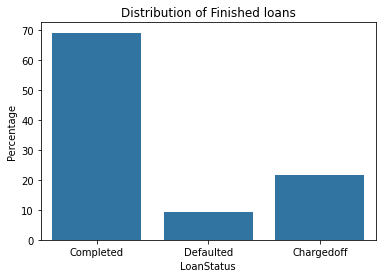

In [8]:
default_color = sb.color_palette()[0]

def plot_relative_bar_from_counts(name, counts, horizontal=False, ntotal=None, **kwargs):
    '''Plot a relative bar chart given a name (xlabel) and a value_counts
    
    If ntotal is an actual number, the percentage will be divided by that instead.
    
    The main reason of kwargs, is for added flexibility, allowing it to
    later being used with something like FacetGrid
    '''
    
    # If num is None, then it will evaluate to False, returning counts.sum(), else it returns itself:
    percentage = (counts / (ntotal or counts.sum())) * 100
    
    if horizontal:
        sb.barplot(y=counts.index, x=percentage, color=default_color);
        plt.xlabel('Percentage');
        plt.ylabel(name);
    else:
        sb.barplot(x=counts.index, y=percentage, color=default_color);
        plt.xlabel(name);
        plt.ylabel('Percentage');
    
def plot_relative_bar(cat_var, **kwargs):
    plot_relative_bar_from_counts(cat_var.name, cat_var.value_counts(), **kwargs)

plot_relative_bar(df_loan_finished.LoanStatus)
plt.title('Distribution of Finished loans');

## Top 5 Most Common Occupations

You might also wonder which occupation lead to more loans overall, and it seems that most of the loans were made by *Professionals*, *Programmers*, *Executives* and *Teachers*.

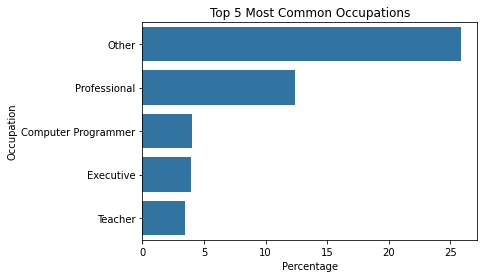

In [9]:
def plot_relative_many_categories(cat_val, n=5, which=0, **kwargs):
    '''
    which: can take 3 values
    - If 1, then only plot top n categories
    - If -1, then only plot bottom n categories
    - If 0 (Default), plot both of them using subplot
    
    - You want to use either 1 or -1 for use with FacetGrid
    '''
    # Once again, kwargs is for compatibility with other functions
    ntotal = cat_val.count()
    counts = cat_val.value_counts()
    counts.index = counts.index.astype('str') # Important so that the plot doesn't plot all the categories
    
    large_counts = counts.iloc[:n]
    small_counts = counts.iloc[-n:]
    
    if(not which):
        plt.subplot(2, 1, 1)
        plot_relative_bar_from_counts(cat_val.name, large_counts, horizontal=True, ntotal=ntotal)
        plt.subplot(2, 1, 2)
        plot_relative_bar_from_counts(cat_val.name, small_counts, horizontal=True, ntotal=ntotal)
    elif(which == 1):
        plot_relative_bar_from_counts(cat_val.name, large_counts, horizontal=True, ntotal=ntotal)
    elif(which == -1):
        plot_relative_bar_from_counts(cat_val.name, small_counts, horizontal=True, ntotal=ntotal)

plot_relative_many_categories(df_misc.Occupation, n=5, which=1)
plt.title('Top 5 Most Common Occupations');


## Top 5 Most Common Loan Categories

It also seems that the vast majority of loans (over 50%!) were made for *Debt Consolidation*. *Home Improvement* and *Business* were also pretty common, although not nearly as common.

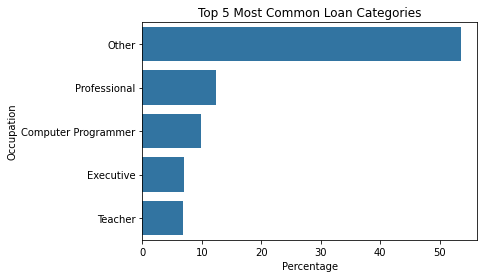

In [10]:
plot_relative_many_categories(df_misc.ListingCategory, n = 5, which=1)
plot_relative_many_categories(df_misc.Occupation, n=5, which=1)
plt.title('Top 5 Most Common Loan Categories');

## The Effect of a Borrower's Rate on Loan Completion

Here is, where we'll switch gears a little bit and starts focusing more on what factors lead to a completed loans. and it seems that most completed loans tend to have a low rate value, somewhere around 10%-20%.

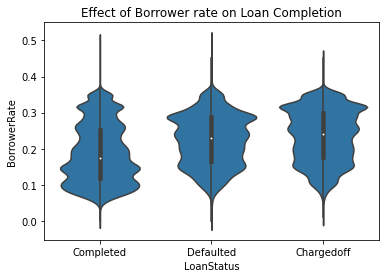

In [11]:
df_loan_finished_loan = df_loan.drop('LoanStatus', axis=1).merge(df_loan_finished, on='ListingNumber')

sb.violinplot(data=df_loan_finished_loan, x='LoanStatus', y='BorrowerRate', color=default_color);
plt.title('Effect of Borrower rate on Loan Completion');

Also take note that most defaulted/chargedoff loans are around 30% borrower rate. However, keep in mind that doesn't tell the whole story, there are still way more completed loans than defaulted or chargedoff. So, we'll use a pie chart to find the exact percentage.

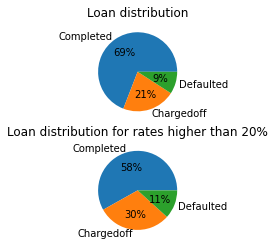

In [12]:
high_rate = df_loan_finished_loan.query('BorrowerRate > 0.2').LoanStatus
high_rate_counts = high_rate.value_counts()
all_rate_counts = df_loan_finished.LoanStatus.value_counts()

plt.subplot(2, 1, 1)
plt.pie(all_rate_counts, labels=all_rate_counts.index, autopct = '%d%%');
plt.title('Loan distribution');
plt.subplot(2, 1, 2)
plt.pie(high_rate_counts, labels=high_rate_counts.index, autopct = '%d%%');
plt.title('Loan distribution for rates higher than 20%');

It is somewhat of a notable increase, so be careful when offering loans with a rate higher than 20%.

## The Effect of Occupation on Loan Completion

You might also be wondering which occupations lead to more completed loans. Most of Defaulted/Chargedoff loans came from Occupations listed as *Other*, while *Professional* have fared decently with regards to completed loans.

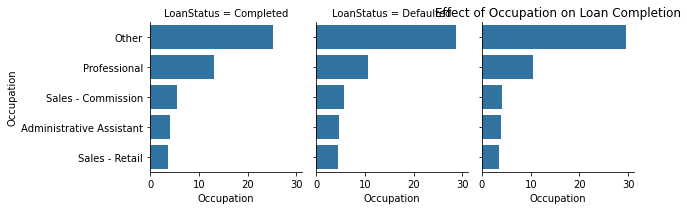

In [13]:
df_loan_finished_misc = df_loan_finished.merge(df_misc)

g = sb.FacetGrid(df_loan_finished_misc, col='LoanStatus')
g.map(plot_relative_many_categories, 'Occupation', horizontal=True, which=1);
plt.ylabel('Percentage');
plt.title('Effect of Occupation on Loan Completion');

## The Effect of Loan Category on Loan Completion

Finally, we'll end this presentation with discussing the effect of loan categories. And it seems that a very high percentage of Defaulted loans come from Debt Conslidation.

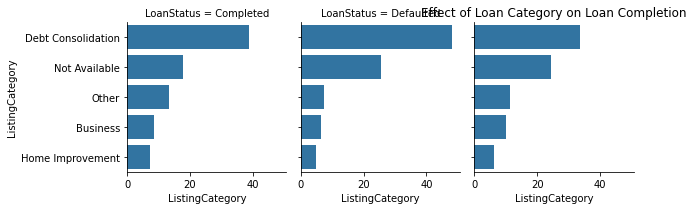

In [14]:
g = sb.FacetGrid(df_loan_finished_misc, col='LoanStatus')
g.map(plot_relative_many_categories, 'ListingCategory', horizontal=True, which=1);
plt.ylabel('Percentage');
plt.title('Effect of Loan Category on Loan Completion');